##### This script will associate spoken phrases with their corresponding translation, using Dynamic Time Warping (DTW) algorithm on MFCC of audio recordings. This example will rely on 10 phrases I recorded myself saying 10 times each.

## 1) Load Packages

In [56]:
# Load packages

import pandas as pd
import cv2
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# import matplotlib.pylab as plt
from skimage import data, img_as_float
from skimage import exposure
import random
import itertools
import librosa
import librosa.display
import IPython.display as ipd

%matplotlib inline

## 2) Load Data and Compute MFCCs

In [76]:
prompt_master = pd.read_csv('../data/recorded/recorded_prompts.txt', sep="|", 
                      header=None, names=['prompt_id','prompt'])

prompt_master.head()
num_classes = len(prompt_master['prompt']) 
print('Unique prompts:', num_classes)

Unique prompts: 10


In [77]:
# LOAD ONLY 1 RECORD IN TRAINING AND 1 RECORD IN TEST FOR EACH PROMPT - like TORGO data

mfcc = []
prompts = []
prompt_text = []
train = []

for p in range(1,11):
    print(prompt_master['prompt'][p-1])
    for i in range(1,3):
        aud_loc = '../data/recorded/' + str(p) + '_' + str(i) + '.wav'
        #print(aud_loc)
        data, rate = librosa.load(aud_loc)
        #print(data.shape)
        mfcc.append(librosa.feature.mfcc(data, rate))
        
        prompts.append(p-1)
        prompt_text.append(prompt_master['prompt'][p-1])
        
        train.append(1 if i <= 1 else -1)

what day is today
how are you
i am hungry
i need to go to the bathroom
i am tired
i am happy
i am sad
the quick brown fox jumped over the lazy dog
i want to go for a walk
please turn on the tv


{0: 'what day is today', 1: 'how are you', 2: 'i am hungry', 3: 'i need to go to the bathroom', 4: 'i am tired', 5: 'i am happy', 6: 'i am sad', 7: 'the quick brown fox jumped over the lazy dog', 8: 'i want to go for a walk', 9: 'please turn on the tv'}


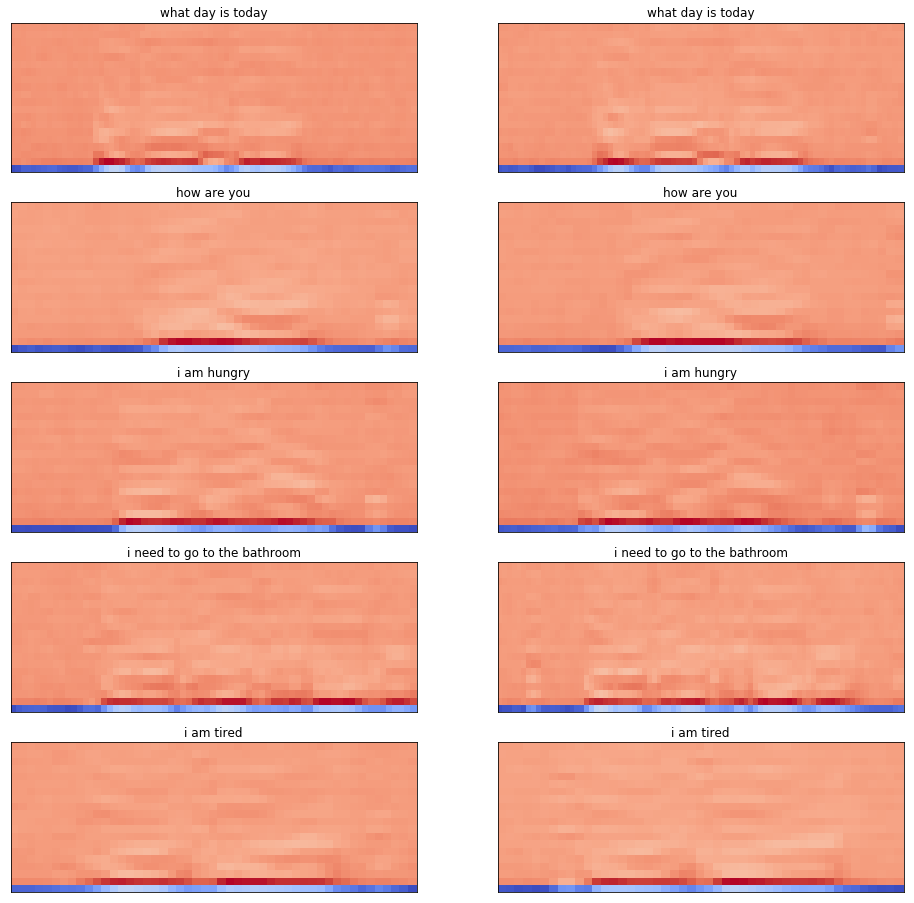

In [78]:
cat = dict(zip(prompts, prompt_text))  # Dictionary to look up prompt text from prompt code
num_examples = 10

fig = plt.figure(figsize=(16, 16))

for i in range(num_examples):
    plt.subplot(5,2,i+1)
    librosa.display.specshow(mfcc[i])
    plt.title(cat.get(prompts[i]))
    
print(cat)

## 3) Compare using DTW

In [34]:
from scipy.spatial.distance import euclidean
from numpy.linalg import norm
from fastdtw import fastdtw

In [79]:
x_train = [mfcc[i] for i,x in enumerate(train) if x==1]
y_train = [prompts[i] for i,x in enumerate(train) if x==1]
x_test = [mfcc[i] for i,x in enumerate(train) if x==-1]
y_test = [prompts[i] for i,x in enumerate(train) if x==-1]

In [80]:
# Create 10 x 10 matrix - where each row represents the distance calculated by the algorithm
dtw_dist = []
for i,x in enumerate(x_test):
    dist = []
    for i2,x2 in enumerate(x_train):
        #distance, path = fastdtw(x.T, x2.T, dist=euclidean)
        distance, path = fastdtw(x.T, x2.T, dist=lambda x, y: norm(x - y, ord=1))
        dist.append(distance)
    dtw_dist.append(dist)

In [81]:
# Show the distances
pd.DataFrame(dtw_dist, prompt_master['prompt'], prompt_master['prompt'])

prompt,what day is today,how are you,i am hungry,i need to go to the bathroom,i am tired,i am happy,i am sad,the quick brown fox jumped over the lazy dog,i want to go for a walk,please turn on the tv
prompt,,,,,,,,,,
what day is today,9053.854438,16909.030622,19601.100819,24605.112349,26452.027365,17451.003573,25189.013062,48273.871624,25468.024309,25304.703376
how are you,20831.178261,5695.966654,12653.260705,22903.562042,13327.718488,11253.725854,14375.953178,37947.748874,19232.751462,20161.352003
i am hungry,18646.107771,13017.297291,7714.936523,20073.457504,10916.618264,12191.554472,13361.692612,44591.693817,22261.705143,24034.104529
i need to go to the bathroom,21270.266883,24362.223727,23771.641243,13399.112697,21633.857467,25094.188745,23749.047055,42427.899786,23586.839260,25109.232850
i am tired,21418.593649,16239.459920,11721.217268,19604.236062,6393.221397,12440.608850,9382.018353,36510.204712,18054.220313,22416.094985
i am happy,20597.063085,15317.141597,10705.593893,18281.049978,8864.811539,10653.180330,10549.140865,37145.961637,20982.285174,17910.413984
i am sad,24239.919037,14862.162834,13564.880084,17001.765465,10315.216148,10387.810844,6859.635133,47031.923995,21241.622400,31154.600129
the quick brown fox jumped over the lazy dog,49760.799649,54536.449380,47501.826453,41257.563434,38933.352634,37885.517610,50145.248107,27695.253225,41533.328653,44909.618496
i want to go for a walk,24884.762264,25741.798330,22019.413028,22638.991663,19680.117665,21310.072535,19900.949146,36714.001584,9983.494600,24049.052487


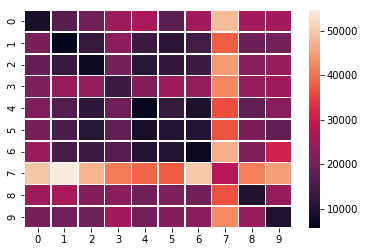

In [82]:
ax = sns.heatmap(dtw_dist, linewidth=0.5)
plt.show()

In [83]:
fmt = '{:<50}{}'
num_correct = 0

print(fmt.format('Correct', 'Predicted'))
print('----------------------------------------------------------------------')

for i,x in enumerate(dtw_dist):
    print(fmt.format(cat.get(i), cat.get(x.index(min(x)))))
    if i == x.index(min(x)): num_correct += 1
        
print('----------------------------------------------------------------------')    
print('% Correct:', num_correct / 10.0 * 100)

Correct                                           Predicted
----------------------------------------------------------------------
what day is today                                 what day is today
how are you                                       how are you
i am hungry                                       i am hungry
i need to go to the bathroom                      i need to go to the bathroom
i am tired                                        i am tired
i am happy                                        i am tired
i am sad                                          i am sad
the quick brown fox jumped over the lazy dog      the quick brown fox jumped over the lazy dog
i want to go for a walk                           i want to go for a walk
please turn on the tv                             please turn on the tv
----------------------------------------------------------------------
% Correct: 90.0
